# Student Performance Classification

This notebook performs EDA and model evaluation for the synthetic student dataset. It mirrors the `src/train.py` script but is interactive for plotting and exploration.

In [1]:
# Imports and setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='whitegrid')
%matplotlib inline


In [2]:
# Load dataset
df = pd.read_csv('../data/students.csv')
print('Rows, cols:', df.shape)
df.head()

# Quick missing value summary
print('\nMissing values per column:')
print(df.isna().sum())


Rows, cols: (500, 5)

Missing values per column:
MST_Score           5
Quiz_Avg            5
Attendance          0
Assignment_Score    5
Category            0
dtype: int64


c:\Users\tabasum\Desktop\SmartEdu_Classifier\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tabasum\Desktop\SmartEdu_Classifier\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tabasum\Desktop\SmartEdu_Classifier\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tabasum\Desktop\SmartEdu_Classifier\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na 

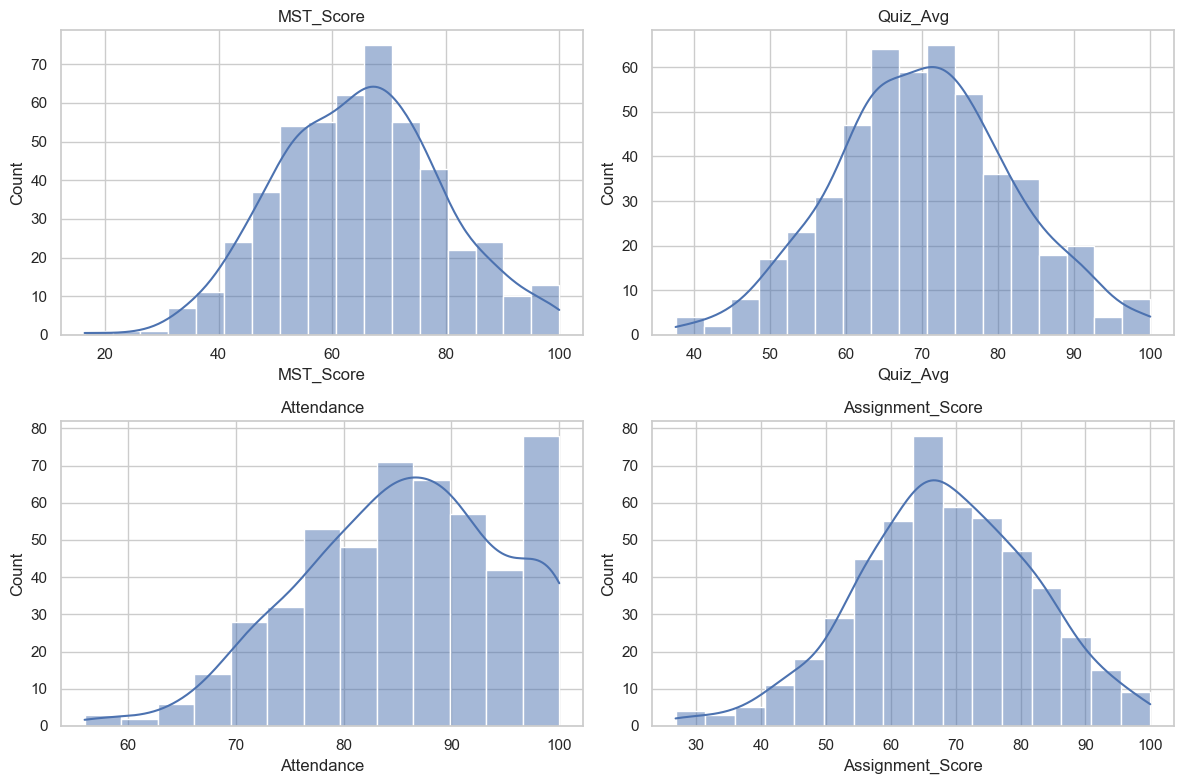

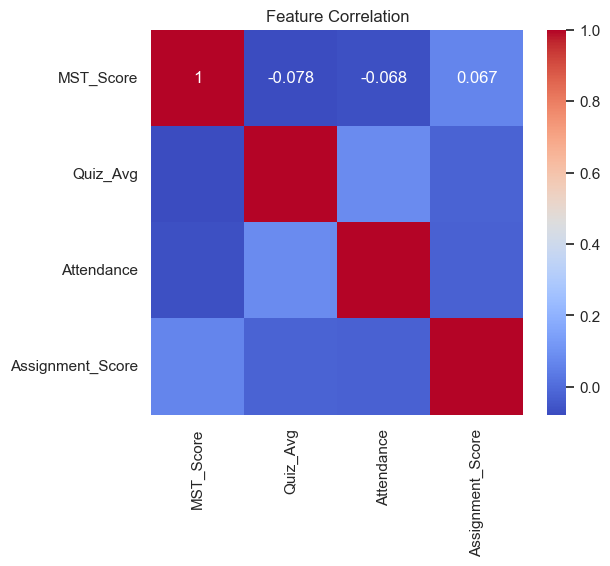


Classification report for saved model:
                   precision    recall  f1-score   support

Average Performer       0.93      1.00      0.97        84
   High Performer       1.00      0.94      0.97        34
Needs Improvement       1.00      0.43      0.60         7

         accuracy                           0.95       125
        macro avg       0.98      0.79      0.85       125
     weighted avg       0.96      0.95      0.95       125



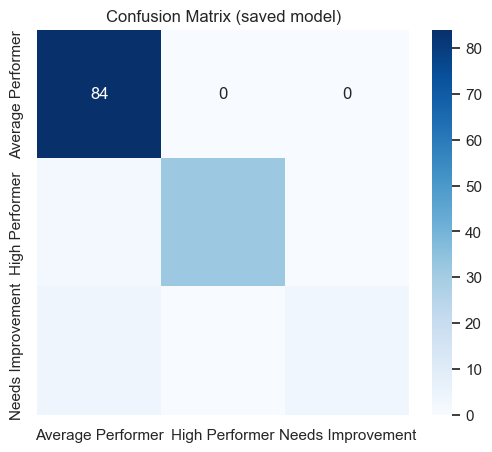

In [3]:
# EDA: distributions and correlation
features = ['MST_Score','Quiz_Avg','Attendance','Assignment_Score']
plt.figure(figsize=(12,8))
for i, col in enumerate(features, 1):
    plt.subplot(2,2,i)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(col)
plt.tight_layout()

plt.figure(figsize=(6,5))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

# Load saved model (if present) and evaluate on held-out set using same preprocessing as src/train.py
model_path = '../models/best_model.joblib'
if os.path.exists(model_path):
    artifacts = joblib.load(model_path)
    model = artifacts['model']
    scaler = artifacts['scaler']
    imputer = artifacts['imputer']
    le = artifacts['label_encoder']

    X = df[features].copy()
    X_imp = pd.DataFrame(imputer.transform(X), columns=features)
    X_scaled = pd.DataFrame(scaler.transform(X_imp), columns=features)

    # We'll do a quick train/test split similar to script
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, le.transform(df['Category']), test_size=0.25, random_state=42, stratify=le.transform(df['Category']))

    preds = model.predict(X_test)
    print('\nClassification report for saved model:')
    print(classification_report(y_test, preds, target_names=le.classes_))
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
    plt.title('Confusion Matrix (saved model)')
    plt.show()
else:
    print('No saved model found at', model_path)


## Model training and comparison

Below we replicate the training logic from `src/train.py` interactively:
- Preprocess (impute + scale) and encode labels
- Train multiple models and compute metrics + 5-fold CV
- Save comparison plots and pick the best model
- Plot confusion matrix and ROC curves for the best model
- Save model artifacts (model + preprocessors)

In [4]:
# Preprocessing and split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer

features = ['MST_Score','Quiz_Avg','Attendance','Assignment_Score']
X = df[features].copy()
y = df['Category'].copy()

imp = SimpleImputer(strategy='mean')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=features)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imp), columns=features)

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.25, random_state=42, stratify=y_enc
)

print('Shapes ->', X_train.shape, X_test.shape)
list(le.classes_)

Shapes -> (375, 4) (125, 4)


['Average Performer', 'High Performer', 'Needs Improvement']

In [5]:
# Train models and compare
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    'LogReg': LogisticRegression(max_iter=1000, random_state=42),
    'Tree': DecisionTreeClassifier(random_state=42),
    'RF': RandomForestClassifier(n_estimators=200, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'SVC': SVC(probability=True, random_state=42),
}
try:
    from xgboost import XGBClassifier
    models['XGB'] = XGBClassifier(
        n_estimators=300, learning_rate=0.1, max_depth=4,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        objective='multi:softprob', random_state=42, eval_metric='mlogloss', n_jobs=-1)
except Exception:
    pass

results = {}
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)
    results[name] = {
        'model': mdl,
        'accuracy': accuracy_score(y_test, preds),
        'precision_macro': precision_score(y_test, preds, average='macro', zero_division=0),
        'recall_macro': recall_score(y_test, preds, average='macro', zero_division=0),
        'f1_macro': f1_score(y_test, preds, average='macro', zero_division=0),
    }

import numpy as np
from sklearn.model_selection import cross_val_score
for name, info in results.items():
    scores = cross_val_score(info['model'], X_scaled, y_enc, cv=5)
    info['cv_mean'] = float(np.mean(scores))

metrics_df = pd.DataFrame([
    {'model': n, 'accuracy': i['accuracy'], 'precision_macro': i['precision_macro'], 'recall_macro': i['recall_macro'], 'f1_macro': i['f1_macro'], 'cv_mean_acc': i['cv_mean']} 
    for n, i in results.items()
]).sort_values('f1_macro', ascending=False)
metrics_df

,model,accuracy,precision_macro,recall_macro,f1_macro,cv_mean_acc
0,LogReg,0.952,0.977778,0.789916,0.845071,0.946
5,XGB,0.920,0.944073,0.768207,0.817875,0.906
4,SVC,0.920,0.956280,0.756536,0.816477,0.938
3,KNN,0.904,0.949088,0.736928,0.801184,0.898
1,Tree,0.808,0.696324,0.764939,0.716989,0.840
2,RF,0.848,0.906556,0.642157,0.702046,0.894


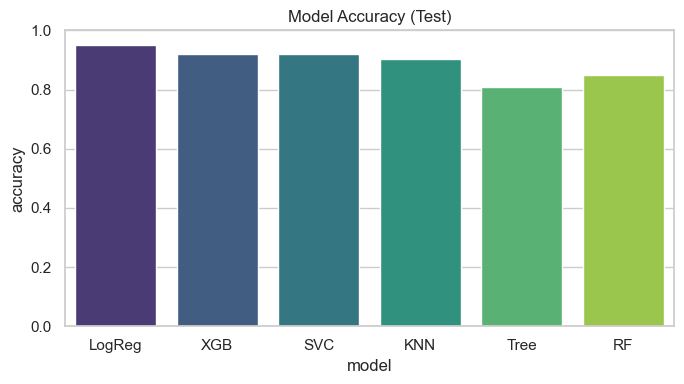

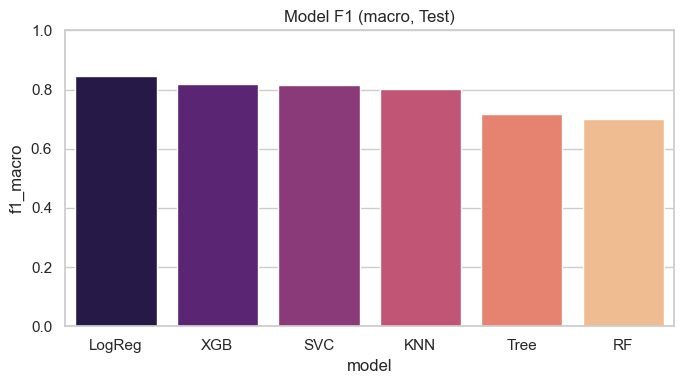

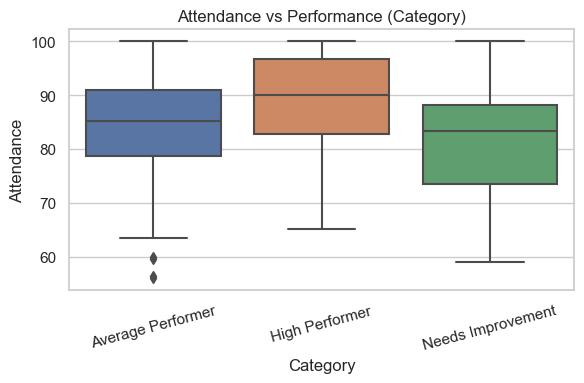

In [6]:
# Visualize model comparison and attendance vs performance
import seaborn as sns
import matplotlib.pyplot as plt
os.makedirs('../outputs', exist_ok=True)

plt.figure(figsize=(7,4))
sns.barplot(data=metrics_df, x='model', y='accuracy', palette='viridis')
plt.title('Model Accuracy (Test)')
plt.ylim(0,1)
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
sns.barplot(data=metrics_df, x='model', y='f1_macro', palette='magma')
plt.title('Model F1 (macro, Test)')
plt.ylim(0,1)
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Category', y='Attendance', order=list(le.classes_))
plt.title('Attendance vs Performance (Category)')
plt.xticks(rotation=15)
plt.tight_layout(); plt.show()

Best model: LogReg

Classification report:
                   precision    recall  f1-score   support

Average Performer       0.93      1.00      0.97        84
   High Performer       1.00      0.94      0.97        34
Needs Improvement       1.00      0.43      0.60         7

         accuracy                           0.95       125
        macro avg       0.98      0.79      0.85       125
     weighted avg       0.96      0.95      0.95       125



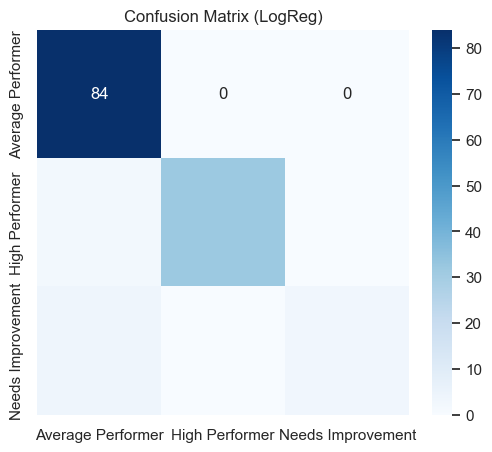

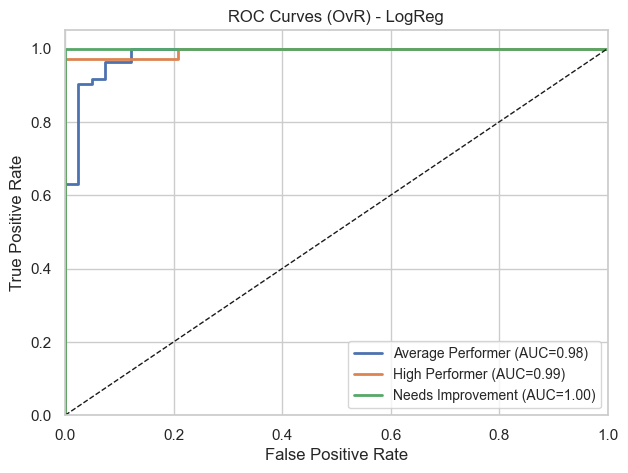

Saved best model to ../models/best_model.joblib


In [7]:
# Evaluate best model + ROC curves, then save artifacts
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

best_name = max(results.keys(), key=lambda k: results[k]['cv_mean'])
best_model = results[best_name]['model']
print('Best model:', best_name)

preds = best_model.predict(X_test)
print('\nClassification report:')
print(classification_report(y_test, preds, target_names=le.classes_))
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title(f'Confusion Matrix ({best_name})')
plt.show()

# ROC curves (OvR) if proba/decision scores available
classes = np.arange(len(le.classes_))
plot_roc = False
y_score = None
if hasattr(best_model, 'predict_proba'):
    y_score = best_model.predict_proba(X_test)
    plot_roc = True
elif hasattr(best_model, 'decision_function'):
    scores = best_model.decision_function(X_test)
    if scores.ndim == 1:
        scores = np.vstack([1 - scores, scores]).T
    e_x = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    y_score = e_x / e_x.sum(axis=1, keepdims=True)
    plot_roc = True

if plot_roc and y_score is not None:
    from sklearn.preprocessing import label_binarize
    y_test_bin = label_binarize(y_test, classes=classes)
    plt.figure(figsize=(7,5))
    for i, label in enumerate(le.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC={roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves (OvR) - {best_name}')
    plt.legend(loc='lower right', fontsize='small')
    plt.show()
else:
    print('Skipping ROC curves (no probability/decision scores available).')

# Save artifacts (mirrors src/train.py)
os.makedirs('../models', exist_ok=True)
joblib.dump({'model': best_model, 'scaler': scaler, 'imputer': imp, 'label_encoder': le}, '../models/best_model.joblib')
print('Saved best model to ../models/best_model.joblib')